In [8]:
import sys
import numpy as np
from numpy.random import MT19937, PCG64, PCG64DXSM, Philox, SFC64, Generator, SeedSequence
from tqdm import tqdm
import time
import pickle
import cv2 
from os.path import exists
sys.path.insert(0,"randomness_testsuite")
from FrequencyTest import FrequencyTest
from RunTest import RunTest
from Matrix import Matrix
from Spectral import SpectralTest
from TemplateMatching import TemplateMatching
from Universal import Universal
from Complexity import ComplexityTest
from Serial import Serial
from ApproximateEntropy import ApproximateEntropy
from CumulativeSum import CumulativeSums
from RandomExcursions import RandomExcursions
import matplotlib.pyplot as plt
import bitstring
from glob import glob
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.util import plotting


In [9]:
files = glob('GeneratedData\\NR*.png')
num_of_files = len(files)

# def get_entropy_spectrum(c, k, sel_img_idx):
def get_entropy_spectrum(c, k, sel_img_idx, rng):
    sel_img = files[sel_img_idx]
    # img = plt.imread(sel_img)
    img = cv2.imread(sel_img)
    # start_x = np.random.randint(img.shape[0] - c)
    # start_y = np.random.randint(img.shape[1] - k)
    start_x = rng.integers(img.shape[0] - c)
    start_y = rng.integers(img.shape[1] - k)


    selected_spectogram = img[start_x:start_x+c, start_y:start_y+k, :].flatten()
    
    random_bits = bitstring.BitArray(float=selected_spectogram[0], length=32)
    
    for i in range(1,selected_spectogram.shape[0]):
        tmp = bitstring.BitArray(float=selected_spectogram[i], length=32) 
        random_bits = random_bits ^ tmp # xor
        random_bits = random_bits ^ random_bits << 13
        random_bits = random_bits ^ random_bits >> 17
        random_bits = random_bits ^ random_bits << 5
    
    return random_bits.uintle, random_bits


In [10]:
# if not exists("entropies.pickle"):
#     rng = np.random.default_rng(12345)
#     entropies = [[[]*num_of_files]*170]*370
#     # entropies = [entropies]
#     for c in tqdm(range(1,370), position=0, desc="c", leave=False, colour='red', ncols=80):
#         # entropies.append([])
#         for k in tqdm(range(1,370), position=1, desc="k", leave=False, colour='green', ncols=80):
#             # entropies[c].append([])
#             for s in range(num_of_files):
#                 entropies[c][k].append(get_entropy_spectrum(c,k,s, rng))

#     file = open("entropies.pickle", "wb")
#     pickle.dump(entropies, file)
#     file.close()

# if not exists("entropies.pickle"):
#     rng = np.random.default_rng(np.random.SeedSequence())
#     # entropies = [[[None]*num_of_files]*170]*370
#     # entropies = [[[]]*170]*370
#     # entropies = np.empty((370,170,num_of_files), dtype=object)
#     entropies = np.empty((370,170,num_of_files), dtype=int)
#     # entropies = [entropies]
#     # for c in tqdm(range(1,370), position=0, desc="c", leave=False, colour='red', ncols=80):
#     it = np.nditer(entropies, flags=['multi_index'])
#     for c in tqdm(it, position=0, desc="c", leave=False, colour='red', ncols=80):
#         # print(it.multi_index)
#         np.put(entropies,[it.multi_index[0],it.multi_index[1],it.multi_index[2]],get_entropy_spectrum(it.multi_index[0]+1,it.multi_index[1]+1,it.multi_index[2], rng))
        
#         # entropies.append([])
#         # for k in tqdm(range(1,170), position=1, desc="k", leave=False, colour='green', ncols=80):
#         # for k in tqdm(np.nditer(entropies[0]), position=1, desc="k", leave=False, colour='green', ncols=80):
#         #     # entropies[c].append([])
#         #     # for s in tqdm(range(num_of_files), position=2, desc="k", leave=False, colour='blue', ncols=80):
#         #     for s in tqdm(np.nditer(entropies[0][0]), position=2, desc="k", leave=False, colour='blue', ncols=80):
#         #         np.put(entropies,[c,k,s],get_entropy_spectrum(c,k,s, rng))
#                 # entropies[c][k][s] = get_entropy_spectrum(c,k,s, rng)
#                 # entropies[c][k].append(get_entropy_spectrum(c,k,s, rng))

#     file = open("entropies.pickle", "wb")
#     pickle.dump(entropies, file)
#     file.close()

Some first experiments of running the code above shows that it would take about 14 and a half day to run the code above on a free account on google colab.
(This is in regards to pickling all entropies), That is using the plt.imread (100 it/s). Using the cv2.imread (130 it/s)The time is reduced a bit over 11 days.
If this were to be done for a single image it would take approximately 8 minutes.

Changed according to this stackOverflow
https://stackoverflow.com/questions/44078327/fastest-approach-to-read-thousands-of-images-into-one-big-numpy-array

In [11]:
# 1st
def get_random_numbers(FRAME_SIZE_VECTOR, generator):
    NUM_OF_ELEMENTS = 512
    SIZE = 2012
    # c_list = np.linspace(1, 250, num=250).astype(int)
    # k_list = np.linspace(1, 250, num=250).astype(int)
    c_list = np.linspace(1, 369, num=369).astype(int)
    k_list = np.linspace(1, 169, num=169).astype(int)
    c_list = [FRAME_SIZE_VECTOR[0]]
    k_list = [FRAME_SIZE_VECTOR[1]]
    # entropies = pickle.load(open("entropies.pickle", "rb"))

    # This creates the entropies (2012 entropies) used as seed for the RNG.
    # entropies = []
    rngs = []
    np.random.shuffle(c_list)
    np.random.shuffle(k_list)
    rng = np.random.default_rng(12345)
    for c_k_idx in range(len(c_list)): # zip(c_list, k_list):
        c = c_list[c_k_idx]
        k = k_list[c_k_idx]
        # sel_img_idx = np.random.randint(0,num_of_files)
        sel_img_idx = rng.integers(0,num_of_files)
        # entropy_val = get_entropy_spectrum(c,k,sel_img_idx)
        # if not exists("entropies.pickle"):
        entropy_val = get_entropy_spectrum(c,k,sel_img_idx, rng)
        # else:
        #   entropy_val = entropies[c][k][sel_img_idx]
        # To be able to run several runs in a row with different rngs used generator variable to set it differently.
        if generator == "PCG64":
            rngs.append(Generator(PCG64(SeedSequence(entropy_val))))
        elif generator == "PCG64DXSM":
            rngs.append(Generator(PCG64DXSM(SeedSequence(entropy_val))))
        elif generator == "MT19937":
            rngs.append(Generator(MT19937(SeedSequence(entropy_val))))
        elif generator == "Philox":
            rngs.append(Generator(Philox(SeedSequence(entropy_val))))
        elif generator == "SFC64":
            rngs.append(Generator(SFC64(SeedSequence(entropy_val))))

        # entropies.append(entropy_val)

    # Creates a list of len = 2012 * 2048 random integers.
    rand_int_sec = []
    # print(f"Len of rngs: {len(rngs)}, Len of entropies: {len(entropies)}")
    for c_k_idx in range(len(c_list)): 
        # np.random.SeedSequence(entropies[c_k_idx])
        # seedSequence = np.random.SeedSequence(entropies[c_k_idx])
        # rng = np.random.default_rng(seedSequence)
        # bitGenerator = np.random.BitGenerator(seedSequence)
        
        for i in range(SIZE):
            # tmp = rng.integers(0, NUM_OF_ELEMENTS, 2048)
            tmp = rngs[c_k_idx].integers(0, NUM_OF_ELEMENTS, 2048)
            # tmp = np.random.randint(0, NUM_OF_ELEMENTS, 2048)
            rand_int_sec.extend(tmp) 
    
    rand_binary_sec = []
    # converts the integers to binary and fills it to keep 
    for i in range(len(rand_int_sec)):
        rand_binary_sec.append("{0:09b}".format(rand_int_sec[i]) )
    binary_data = "".join(rand_binary_sec)
    
    return binary_data

In [12]:
# # 2nd

class DiscreteFourierRandomMax(ElementwiseProblem):
    def __init__(self, rng) -> None:
        super().__init__(n_var=2,
                         n_obj=1,
                         n_ieq_constr=1,
                         xl=np.array([1,1]),
                         xu=np.array([369,169]),
                         vtype=int)
        self.rng = rng
    
    # x = Vector with [M,N] Where: M x N FRAME SIZE to feed as input
    def _evaluate(self, x, out, *args, **kwargs):
        numbers = get_random_numbers(x, self.rng)
        f1 = SpectralTest.spectral_test(numbers)
        

        out["F"] = - f1[0]
        out["G"] = 0.01 - f1[0]
        
problem = DiscreteFourierRandomMax("PCG64")

In [13]:
class NIST_SP800_22rev1a_max(ElementwiseProblem):
    def __init__(self, rng) -> None:
        super().__init__(n_var=2,
                         n_obj=16,
                         n_ieq_constr=16,
                         xl=np.array([1,1]),
                         xu=np.array([369,169]),
                         vtype=int)
        self.rng = rng
    
    # x = Vector with [M,N] Where: M x N FRAME SIZE to feed as input
    def _evaluate(self, x, out, *args, **kwargs):
        numbers = get_random_numbers(x, self.rng)
        f1 = FrequencyTest.monobit_test(numbers)
        f2 = FrequencyTest.block_frequency(numbers)
        f3 = RunTest.run_test(numbers)
        f4 = RunTest.longest_one_block_test(numbers)
        f5 = Matrix.binary_matrix_rank_text(numbers)
        f6 = SpectralTest.spectral_test(numbers)
        f7 = TemplateMatching.non_overlapping_test(numbers)
        f8 = TemplateMatching.overlapping_patterns(numbers)
        f9 = Universal.statistical_test(numbers)
        f10 = ComplexityTest.linear_complexity_test(numbers)
        f11 = Serial.serial_test(numbers)
        f12 = ApproximateEntropy.approximate_entropy_test(numbers)
        f13_0 = CumulativeSums.cumulative_sums_test(numbers,0)
        f13_1 = CumulativeSums.cumulative_sums_test(numbers,1)
        f14 = RandomExcursions.random_excursions_test(numbers)
        f15 = RandomExcursions.variant_test(numbers)
        f14_avg, f15_avg = 0,0
        for i in range(len(f14)):
            f14_avg += f14[i][3]
        for i in range(len(f15)):
            f15_avg += f15[i][3]
        f14_avg, f15_avg = f14_avg / len(f14),f15_avg/len(f15)
        f11_avg = ((f11[0][0] + f11[1][0]) / 2)

        out["F"] = [- f1[0],- f2[0],- f3[0],- f4[0],- f5[0],- f6[0],- f7[0],- f8[0],
            - f9[0],- f10[0],- f11_avg,- f12[0],- f13_0[0],- f13_1[0],- f14_avg,- f15_avg]
        out["G"] = [0.01 - f1[0],
                    0.01 - f2[0],
                    0.01 - f3[0],
                    0.01 - f4[0],
                    0.01 - f5[0],
                    0.01 - f6[0],
                    0.01 - f7[0],
                    0.01 - f8[0],
                    0.01 - f9[0],
                    0.01 - f10[0],
                    0.01 - f11_avg,
                    0.01 - f12[0],
                    0.01 - f13_0[0],
                    0.01 - f13_1[0],
                    0.01 - f14_avg,
                    0.01 - f15_avg]
        
problem2 = NIST_SP800_22rev1a_max("PCG64")

In [14]:
# 3rd
algortihm = NSGA2(
            pop_size = 3, 
            n_offsprings=3,
            sampling=IntegerRandomSampling(),
            crossover=SBX(vtype=float, repair=RoundingRepair()),
            mutation=PM(vtype=float, repair=RoundingRepair()),
            eliminate_duplicates=True)



In [15]:
# May choose to not use this and the algorithm terminates when no significant progress has been made.
termination = get_termination("n_gen", 3)

In [16]:
# #4th
# res = minimize(problem, algortihm, termination, save_history=True, verbose=True)


In [18]:
generators = ["PCG64", "PCG64DXSM", "MT19937", "Philox", "SFC64"]
results1 = []
for generator in tqdm(generators):
    problem = DiscreteFourierRandomMax(generator)
    tic = time.perf_counter()
    res1 = minimize(problem, algortihm, termination, save_history=True, verbose=True)
    toc = time.perf_counter()
    results1.append(res1)
    print(f"Time spent optimizing using {generator}: {toc-tic} seconds")
    print("Best solution found: %s" % res1.X)
    print("Function value: %s" % res1.F)    
    print("Constraint violation: %s" % res1.CV)
    

  0%|          | 0/5 [00:00<?, ?it/s]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |        6 |      1 |  0.000000E+00 |  0.000000E+00 |  0.2519164294 |         ideal


 20%|██        | 1/5 [05:37<22:29, 337.36s/it]

     3 |        9 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0156221183 |         ideal
Time spent optimizing using PCG64: 337.3556242000777 seconds
Best solution found: [ 33 165]
Function value: [-0.98244742]
Constraint violation: [0.]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |        6 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


 40%|████      | 2/5 [11:09<16:42, 334.33s/it]

     3 |        9 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
Time spent optimizing using PCG64DXSM: 332.1987521999981 seconds
Best solution found: [128  14]
Function value: [-0.87238089]
Constraint violation: [0.]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |        6 |      1 |  0.000000E+00 |  0.000000E+00 |  0.2638825627 |         ideal


 60%|██████    | 3/5 [15:00<09:34, 287.08s/it]

     3 |        9 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0296084452 |         ideal
Time spent optimizing using MT19937: 230.86483840015717 seconds
Best solution found: [34 18]
Function value: [-0.73979892]
Constraint violation: [0.]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |        6 |      1 |  0.000000E+00 |  0.000000E+00 |  0.2186267306 |         ideal


 80%|████████  | 4/5 [19:56<04:50, 290.74s/it]

     3 |        9 |      1 |  0.000000E+00 |  0.000000E+00 |  0.1877004586 |         ideal
Time spent optimizing using Philox: 296.3529791000765 seconds
Best solution found: [170  52]
Function value: [-0.9838899]
Constraint violation: [0.]
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |        6 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


100%|██████████| 5/5 [26:48<00:00, 321.63s/it]

     3 |        9 |      1 |  0.000000E+00 |  0.000000E+00 |  0.1908160699 |         ideal
Time spent optimizing using SFC64: 411.38717040000483 seconds
Best solution found: [190 128]
Function value: [-0.86763555]
Constraint violation: [0.]


A test with all generators for only SPectral test. 
PCG64: 6m 22s, 0.93322868
PCG64DXSM: 10m 8s 0.89164475
MT19937: 7m 45s 0.88426397
Philox: 6m 12s 0.88212301
SFC64: 6m 4s 0.99807628

36m 8.2s total

Short test with old way of creating rng with numpy: 6m 45.6s
https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
Short first test with new way of creating rng with numpy:  9m 21.2s
Short Second test with new way of creating rng with numpy:  7m 1.2s
Short third test with new way (PCG64) of creating rng with numpy:  5m 2.2s
Short third test with new way (PCG64DXSM) of creating rng with numpy:  7m 11.8s
Short third test with new way (MT19937) of creating rng with numpy:  10m 3.9s 
Short third test with new way (Philox) of creating rng with numpy:  
Short third test with new way (SFC64) of creating rng with numpy:  


In [19]:
generators = ["PCG64", "PCG64DXSM", "MT19937", "Philox", "SFC64"]
results = []
for generator in tqdm(generators):
    problem = NIST_SP800_22rev1a_max(generator)
    tic = time.perf_counter()
    res = minimize(problem, algortihm, termination, save_history=True, verbose=True)
    toc = time.perf_counter()
    results.append(res)
    print(f"Time spent optimizing using {generator}: {toc-tic} seconds")
    print("Best solution found: %s" % res.X)
    print("Function value: %s" % res.F)
    print("Constraint violation: %s" % res.CV)
    print()
    

  0%|          | 0/5 [00:00<?, ?it/s]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      3 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |        6 |      3 |  0.000000E+00 |  0.000000E+00 |  2.1111112833 |         ideal


 20%|██        | 1/5 [5:05:38<20:22:33, 18338.35s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  1.6159573687 |         ideal
Time spent optimizing using PCG64: 18338.399562899955 seconds
Best solution found: [[ 52  52]
 [ 13 106]
 [ 28  47]]
Function value: [[-0.17053174 -0.84722223 -0.93144568 -0.66058365 -0.13216645 -0.93802232
  -0.14092981 -0.1848495  -0.87249577 -0.19974834 -0.30750623 -0.62901699
  -0.30065691 -0.2978746  -0.47499364 -0.47298012]
 [-0.19195646 -0.61389309 -0.96040904 -0.66558586 -0.63433971 -0.57263064
  -0.07862658 -0.14990317 -0.34171009 -0.54577629 -0.86951284 -0.88064851
  -0.15603617 -0.16103591 -0.68222696 -0.68815506]
 [-0.83044574 -0.85889897 -0.29298598 -0.53694859 -0.27381493 -0.44164369
  -0.65930419 -0.56653084 -0.61313305 -0.32824244 -0.46157869 -0.68325033
  -0.8491966  -0.93555397 -0.31329445 -0.37604383]]
Constraint violation: [[0.]
 [0.]
 [0.]]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      1 |  0.000000E+00 | 

 40%|████      | 2/5 [10:11:33<15:17:25, 18348.42s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  2.0911889925 |         ideal
Time spent optimizing using PCG64DXSM: 18355.4889901001 seconds
Best solution found: [[354  88]
 [354  78]
 [139 125]]
Function value: [[-0.41086975 -0.83375626 -0.22652687 -0.10501942 -0.79092417 -0.17236495
  -0.02284469 -0.04169211 -0.79805046 -0.64857763 -0.05853803 -0.76942508
  -0.56044681 -0.46684445 -0.54599217 -0.59990872]
 [-0.67901372 -0.01296003 -0.27801032 -0.63783135 -0.90780926 -0.17104199
  -0.87380134 -0.50443588 -0.6998702  -0.66106674 -0.35555374 -0.01151047
  -0.50763339 -0.66374118 -0.63646472 -0.50418641]
 [-0.57842493 -0.41496109 -0.89025056 -0.66037219 -0.67104242 -0.59414569
  -0.44053413 -0.86119087 -0.84288386 -0.73979758 -0.42618828 -0.22433898
  -0.43797297 -0.87380036 -0.56447103 -0.56361297]]
Constraint violation: [[0.]
 [0.]
 [0.]]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      2 |  0.000000E+00 

 60%|██████    | 3/5 [15:16:28<10:10:48, 18324.02s/it]

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  1.9767080787 |         ideal
Time spent optimizing using MT19937: 18294.942981100176 seconds
Best solution found: [[139  55]
 [151  52]
 [148  52]]
Function value: [[-0.90952844 -0.27187711 -0.9714419  -0.99709628 -0.87927359 -0.39154412
  -0.63033401 -0.01304246 -0.74380534 -0.62065106 -0.06548681 -0.4121099
  -0.64079024 -0.74700121 -0.38659825 -0.23929432]
 [-0.24286243 -0.44925264 -0.09049699 -0.14610863 -0.04166598 -0.46083392
  -0.07527898 -0.01109237 -0.89313542 -0.57710937 -0.65146424 -0.84564326
  -0.2314476  -0.40789085 -0.48771691 -0.58926631]
 [-0.25691776 -0.58733174 -0.58645446 -0.31119795 -0.54850069 -0.4763666
  -0.63460769 -0.10034341 -0.52777242 -0.55718866 -0.73750109 -0.46402597
  -0.16482696 -0.4995963  -0.44206527 -0.73939745]]
Constraint violation: [[0.]
 [0.]
 [0.]]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      3 |  0.000000E+00 | 

 80%|████████  | 4/5 [20:19:37<5:04:30, 18270.47s/it] 

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  2.2593163782 |         ideal
Time spent optimizing using Philox: 18188.385831400054 seconds
Best solution found: [[323  62]
 [260  51]
 [322  62]]
Function value: [[-0.39919797 -0.83228525 -0.6611513  -0.9312013  -0.77459825 -0.68256073
  -0.75335714 -0.54931015 -0.77554395 -0.26171241 -0.23638858 -0.39387693
  -0.18866451 -0.49666921 -0.49412927 -0.42060749]
 [-0.1281991  -0.82442306 -0.16299255 -0.1388643  -0.374502   -0.99110296
  -0.65058705 -0.63614541 -0.50380035 -0.04095067 -0.33850746 -0.87616106
  -0.17897847 -0.14061523 -0.48526268 -0.34593964]
 [-0.6577377  -0.66312703 -0.34861514 -0.83239509 -0.72968079 -0.53410966
  -0.88477753 -0.78842649 -0.87176212 -0.57849451 -0.56915826 -0.06188188
  -0.72420437 -0.98748846 -0.74739035 -0.40948199]]
Constraint violation: [[0.]
 [0.]
 [0.]]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        3 |      3 |  0.000000E+00 |

100%|██████████| 5/5 [25:23:18<00:00, 18279.75s/it]  

     3 |        9 |      3 |  0.000000E+00 |  0.000000E+00 |  1.3540786395 |         ideal
Time spent optimizing using SFC64: 18221.559169200016 seconds
Best solution found: [[343  58]
 [340  62]
 [312  58]]
Function value: [[-0.69132326 -0.93012871 -0.10735026 -0.53686414 -0.6331127  -0.87618047
  -0.64617718 -0.97077563 -0.17070323 -0.46663347 -0.45258657 -0.12535339
  -0.22394136 -0.46556915 -0.49052906 -0.38799672]
 [-0.57550922 -0.80669584 -0.92277767 -0.68061125 -0.80478141 -0.99687395
  -0.97891873 -0.32135038 -0.93929601 -0.63298786 -0.5046433  -0.66691474
  -0.69505093 -0.72204436 -0.41786676 -0.51913499]
 [-0.50203532 -0.7093427  -0.75085796 -0.94135804 -0.39297271 -0.58894015
  -0.12848155 -0.34890308 -0.70445338 -0.98246436 -0.65168339 -0.88096864
  -0.73006536 -0.65565896 -0.53679493 -0.30819661]]
Constraint violation: [[0.]
 [0.]
 [0.]]



First run of all RNGs and all tests took over 26 hours. 1597m 17.9s
Second with the use of cv2 for images took 1577m 32.5s
Third with no other programs running and no other usage of the computer 1523m 18.8s

An improvement of only 20 minutes, indicates that the main improvement for timing either lies in the NIST tests or pymoo.

In [20]:
import pymoo
allres = pymoo.core.result.Result()
n = 0
for res in results:
    if n == 0:
        allres.X = res.X
        allres.F = res.F
        allres.history = res.history
    else:
        allres.X = np.append(allres.X, res.X, axis=0)
        allres.F = np.append(allres.F, res.F, axis=0)
        allres.history = np.append(allres.history, res.history, axis=0)
    n += 1

    

Best regarding ASF: Point 
i = 5

Best regarding Pseudo Weights: Point 
j = 13



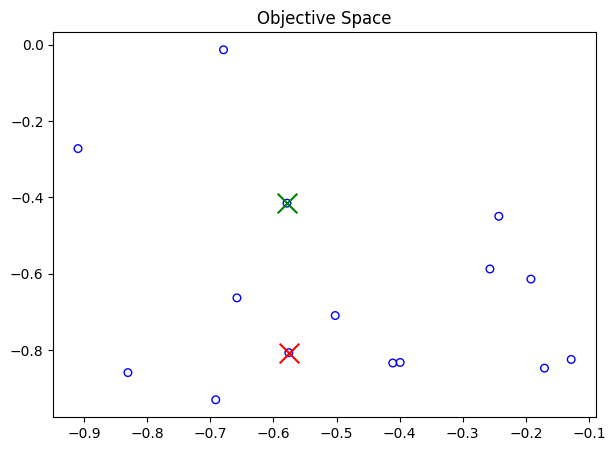

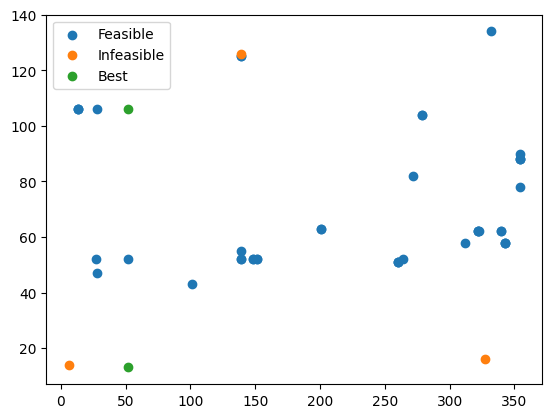

In [21]:
# https://pymoo.org/getting_started/part_3.html
F = allres.F
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
# fl = F.min(axis=0)
# fu = F.max(axis=0)
# for i in range(len(fl)):
#     print(f"Scale f{i+1}: [{fl[i]}, {fu[i]}]")
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

fl = nF.min(axis=0)
fu = nF.max(axis=0)
from pymoo.mcdm.pseudo_weights import PseudoWeights
from pymoo.decomposition.asf import ASF
decomp = ASF()
weights = np.array([0.0625]*16)
i = decomp.do(nF, 1/weights).argmin()
print("Best regarding ASF: Point \ni = %s\n" % (i))
j = PseudoWeights(weights).do(nF)
print("Best regarding Pseudo Weights: Point \nj = %s\n" % (j))
# for i in range(len(fl)):
#     print(f"Scale f{i+1}: [{fl[i]}, {fu[i]}]")
# print(nF[:,0], nF[:,1])
plt.figure(figsize=(7, 5))
plt.scatter(F[:,0], F[:,1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="green", s=200)
plt.scatter(F[j, 0], F[j, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.show()
_X = np.row_stack([a.pop.get("X") for a in allres.history])
feasible = np.row_stack([a.pop.get("feasible") for a in allres.history])[:, 0]

plotting.plot(_X[feasible], _X[np.logical_not(feasible)], allres.X[None,:]
            , labels=["Feasible", "Infeasible", "Best"])

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 2

[1.         0.96753407 0.        ] [0.04765901 1.         0.        ]


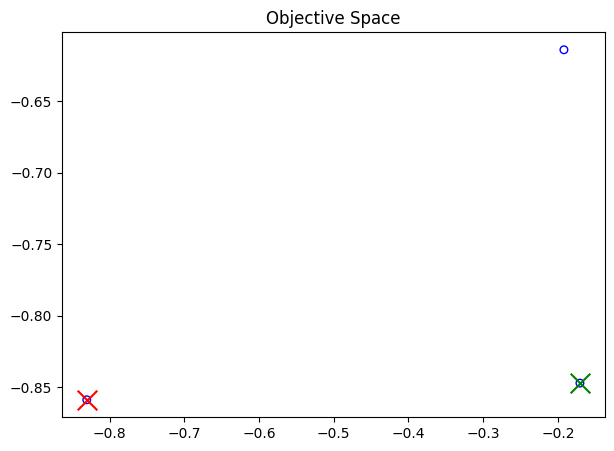

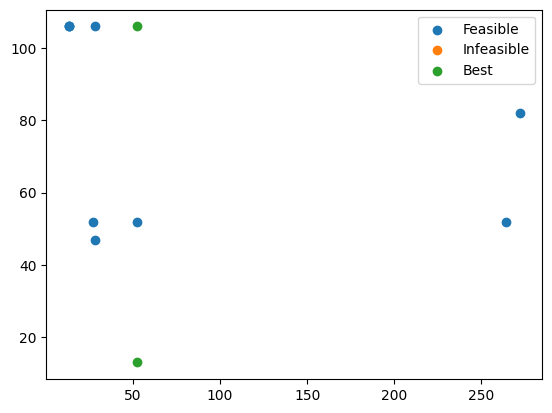

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 2

[1.         0.         0.37512977] [0.         1.         0.51023038]


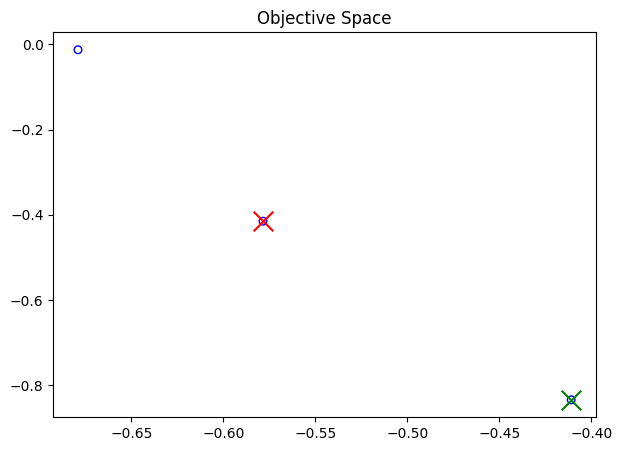

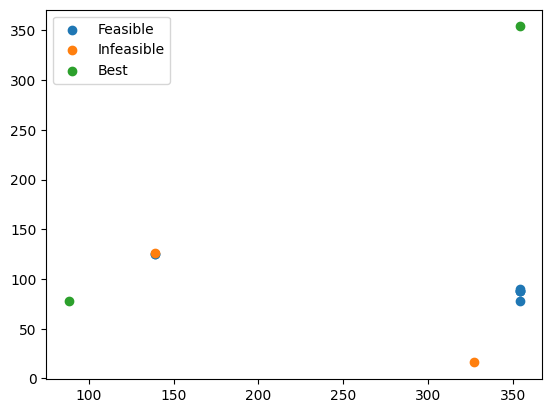

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 2

[0.         1.         0.97891699] [1.         0.43771462 0.        ]


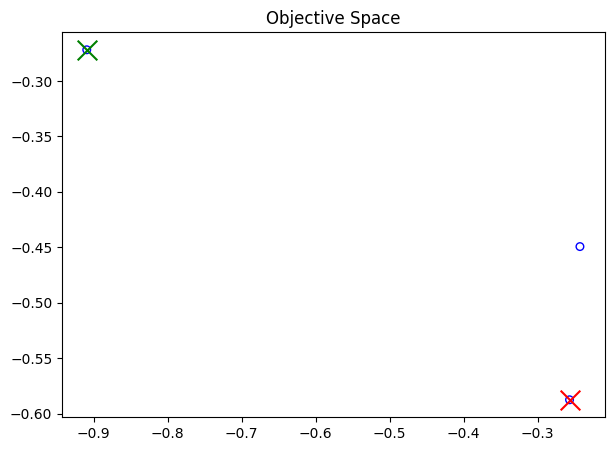

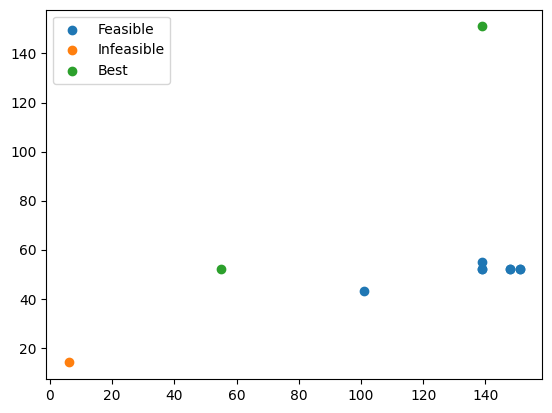

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 2

[0.48823585 1.         0.        ] [0.         0.04647832 1.        ]


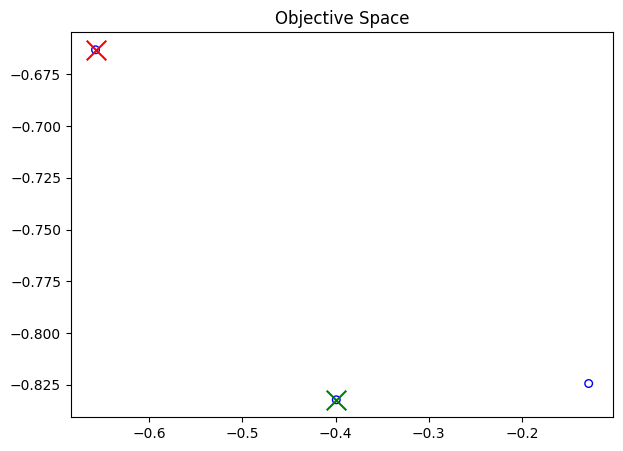

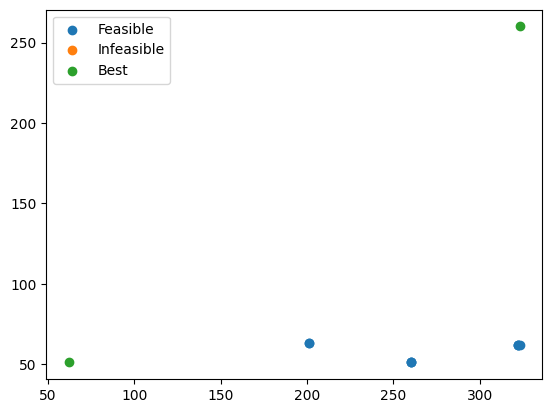

Best regarding ASF: Point 
i = 0

Best regarding Pseudo Weights: Point 
j = 1

[0.         0.61184054 1.        ] [0.         0.55906108 1.        ]


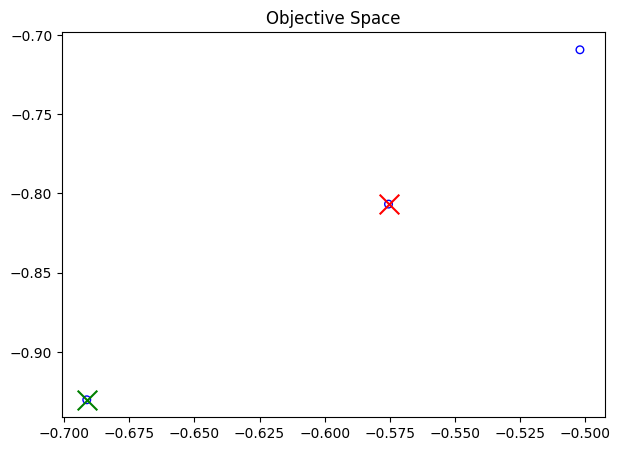

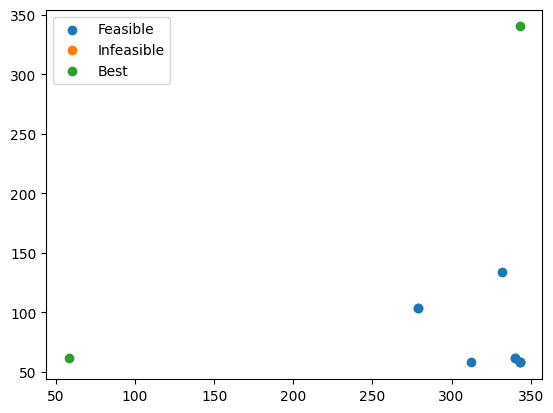

In [22]:
# https://pymoo.org/getting_started/part_3.html
for res in results:
    F = res.F
    approx_ideal = F.min(axis=0)
    approx_nadir = F.max(axis=0)
    # fl = F.min(axis=0)
    # fu = F.max(axis=0)
    # for i in range(len(fl)):
    #     print(f"Scale f{i+1}: [{fl[i]}, {fu[i]}]")
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

    fl = nF.min(axis=0)
    fu = nF.max(axis=0)
    from pymoo.mcdm.pseudo_weights import PseudoWeights
    from pymoo.decomposition.asf import ASF
    decomp = ASF()
    weights = np.array([0.0625]*16)
    i = decomp.do(nF, 1/weights).argmin()
    print("Best regarding ASF: Point \ni = %s\n" % (i))
    j = PseudoWeights(weights).do(nF)
    print("Best regarding Pseudo Weights: Point \nj = %s\n" % (j))
    # for i in range(len(fl)):
    #     print(f"Scale f{i+1}: [{fl[i]}, {fu[i]}]")
    print(nF[:,0], nF[:,1])
    plt.figure(figsize=(7, 5))
    plt.scatter(F[:,0], F[:,1], s=30, facecolors='none', edgecolors='blue')
    plt.scatter(F[i, 0], F[i, 1], marker="x", color="green", s=200)
    plt.scatter(F[j, 0], F[j, 1], marker="x", color="red", s=200)
    plt.title("Objective Space")
    plt.show()
    _X = np.row_stack([a.pop.get("X") for a in res.history])
    feasible = np.row_stack([a.pop.get("feasible") for a in res.history])[:, 0]

    plotting.plot(_X[feasible], _X[np.logical_not(feasible)], res.X[None,:]
              , labels=["Feasible", "Infeasible", "Best"])

Best solution found: [189 117]
Function value: [-0.99230522]
Constraint violation: [0.]


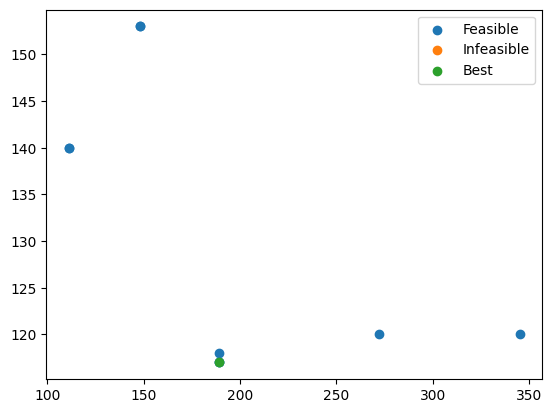

In [54]:
# https://pymoo.org/customization/discrete.html
# the approximated best frame size
print("Best solution found: %s" % res.X)
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)

_X = np.row_stack([a.pop.get("X") for a in res.history])
feasible = np.row_stack([a.pop.get("feasible") for a in res.history])[:, 0]

plotting.plot(_X[feasible], _X[np.logical_not(feasible)], res.X[None,:]
              , labels=["Feasible", "Infeasible", "Best"])

Best regarding ASF: Point 
i = 0
F = [-0.53478778 -0.5529893  -0.31869325 -0.18050299 -0.49914497 -0.92987456
 -0.45270942 -0.28373044 -0.54697707 -0.62372195 -0.84776238 -0.93758783
 -0.65809607 -0.47596469 -0.48426245 -0.52500984]
Best regarding Pseudo Weights: Point 
j = 0
F = [-0.53478778 -0.5529893  -0.31869325 -0.18050299 -0.49914497 -0.92987456
 -0.45270942 -0.28373044 -0.54697707 -0.62372195 -0.84776238 -0.93758783
 -0.65809607 -0.47596469 -0.48426245 -0.52500984]
[0.         0.42773409 1.        ] [0.         1.         0.73290173]


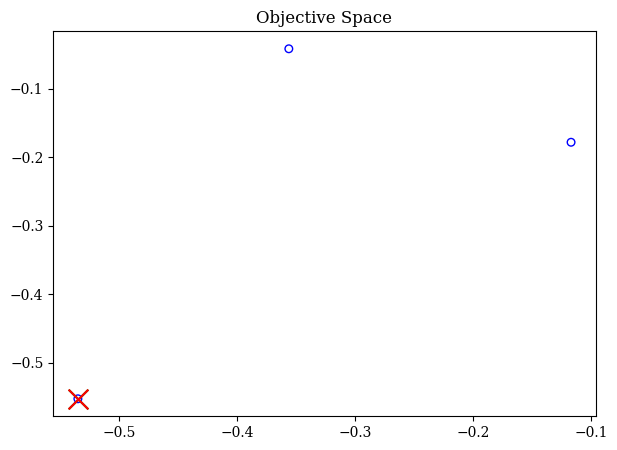

In [94]:
# https://pymoo.org/getting_started/part_3.html
F = res.F
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
# fl = F.min(axis=0)
# fu = F.max(axis=0)
# for i in range(len(fl)):
#     print(f"Scale f{i+1}: [{fl[i]}, {fu[i]}]")
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

fl = nF.min(axis=0)
fu = nF.max(axis=0)
from pymoo.mcdm.pseudo_weights import PseudoWeights
from pymoo.decomposition.asf import ASF
decomp = ASF()
weights = np.array([0.0625]*16)
i = decomp.do(nF, 1/weights).argmin()
print("Best regarding ASF: Point \ni = %s\nF = %s" % (i, F[i]))
j = PseudoWeights(weights).do(nF)
print("Best regarding Pseudo Weights: Point \nj = %s\nF = %s" % (j, F[j]))
# for i in range(len(fl)):
#     print(f"Scale f{i+1}: [{fl[i]}, {fu[i]}]")
print(nF[:,0], nF[:,1])
plt.figure(figsize=(7, 5))
plt.scatter(F[:,0], F[:,1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="green", s=200)
plt.scatter(F[j, 0], F[j, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.show()